In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [272]:
def f(x):
    return 3*x**2 - 4*x + 5

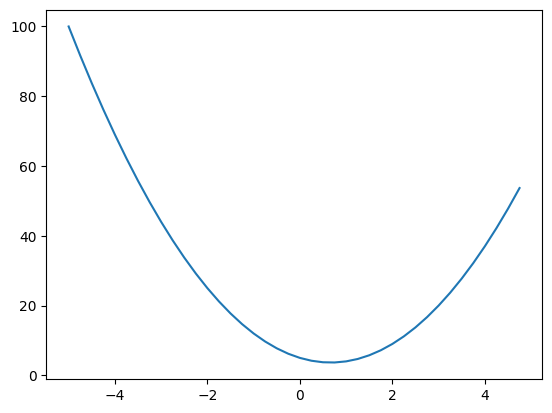

In [273]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [274]:
f(3)

20

In [275]:
h = 0.00001
x = 3.0
(f(x + h) - f(x))/h

14.00003000000538

- We need to accumulate not assign grad because grad from multiple nodes should add up

In [276]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __radd__(self, other):
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():

            self.grad +=  other.data * out.grad
            other.grad +=  self.data * out.grad
        out._backward = _backward
        return out

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def __neg__(self): # -self
        return self * -1

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other):
        return other + -self.data

    def __pow__(self, other, modulo=None):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self, ), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other-1)) * out.grad
        out._backward = _backward

        return out

    def exp(self):
        x = self.data
        out=Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.grad * out.data
        out._backward = _backward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad +=  (1 - t**2) * out.grad
        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()



In [277]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0,  label='c')
e = a*b; e.label = 'e'
d = e + c; d.label  = 'd'
f = Value(-2.0, label='f')
L = d*f; L.label = 'L'
L

Value(data=-8.0)

In [278]:
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [279]:
d._op

'+'

In [281]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        #for any value in the graph, create a rectangular record node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }"% (n.label, n.data, n.grad, ), shape='record')
        if n._op:
            # if this value is the result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

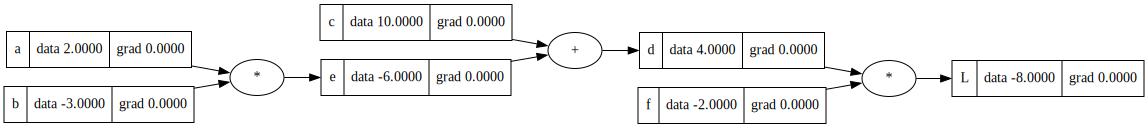

In [282]:
draw_dot(L)

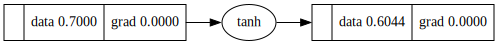

In [283]:
n = Value(0.7)
o = n.tanh()
draw_dot(o)

In [284]:
# neuron

# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.8813735870195432, label='b')

x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'

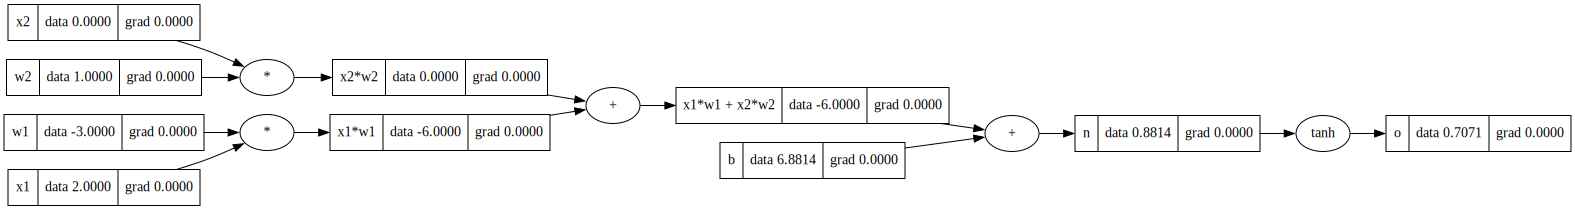

In [285]:
draw_dot(o)

In [286]:
o.grad = 1.0

In [287]:
o._backward()

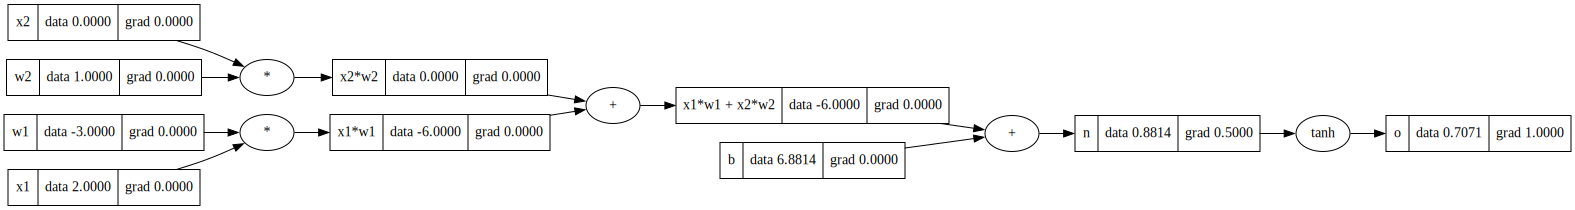

In [288]:
draw_dot(o)

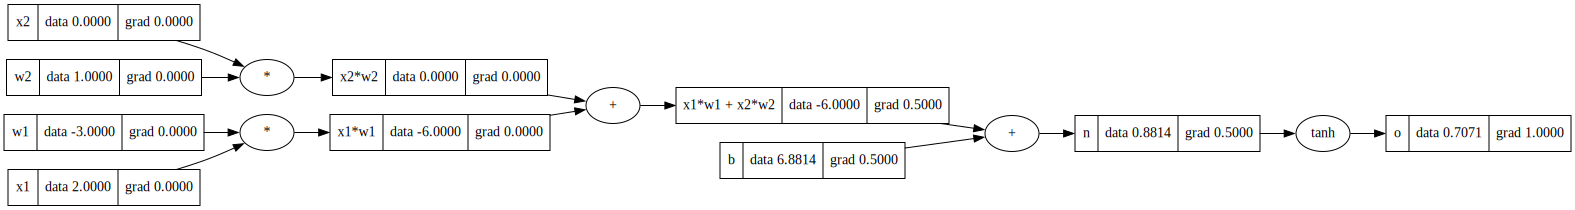

In [289]:
n._backward()
draw_dot(o)

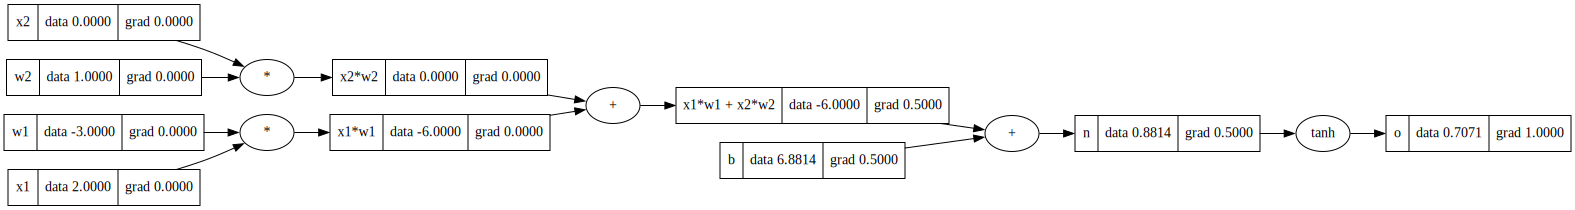

In [290]:
b._backward()
draw_dot(o)

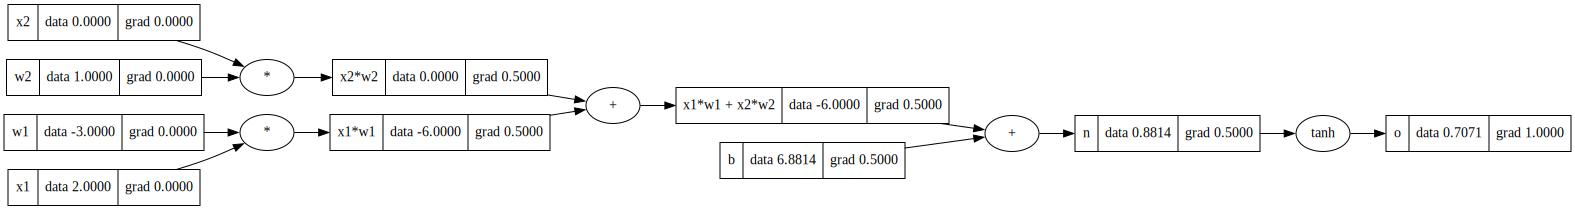

In [291]:
x1w1x2w2._backward()
draw_dot(o)

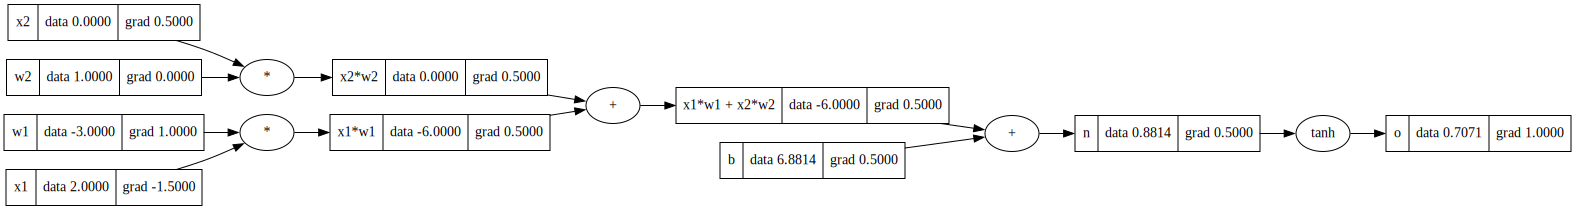

In [292]:
x2w2._backward()
x1w1._backward()
draw_dot(o)

In [293]:
o.backward()

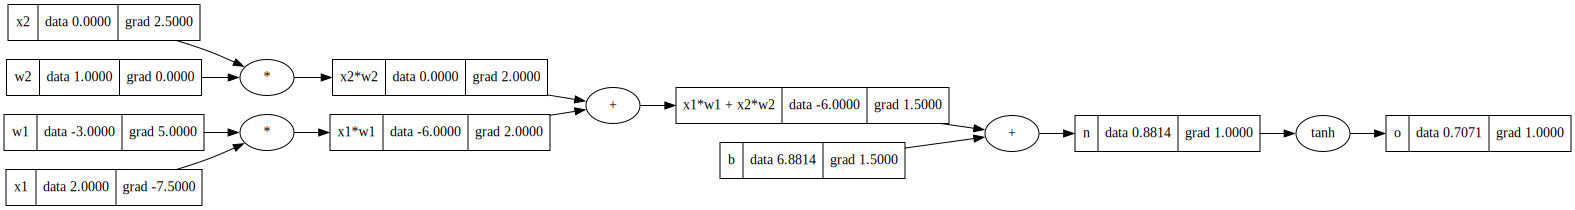

In [294]:
draw_dot(o)

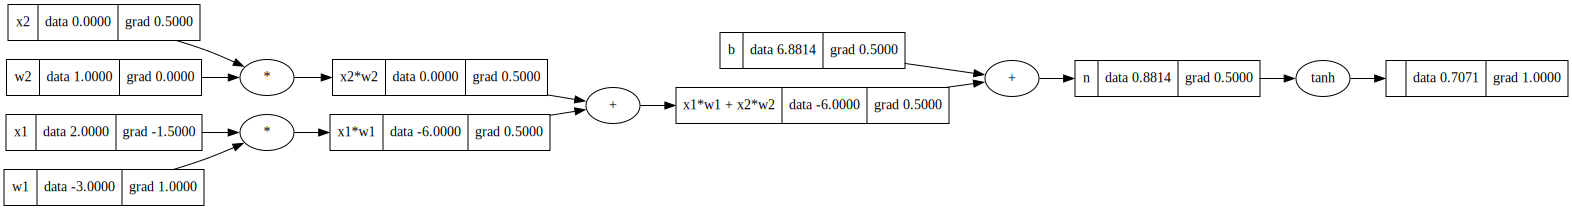

In [295]:
# neuron

# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.8813735870195432, label='b')

x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'

# -----
e = (2*n).exp()
o = (e - 1) / (e + 1); o.label = 'o'
o = n.tanh()
o.backward()
draw_dot(o)

In [296]:
import random

In [297]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]


class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

x = [2.0, 3.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.5644037430952062)

In [298]:
len(n.parameters())

41

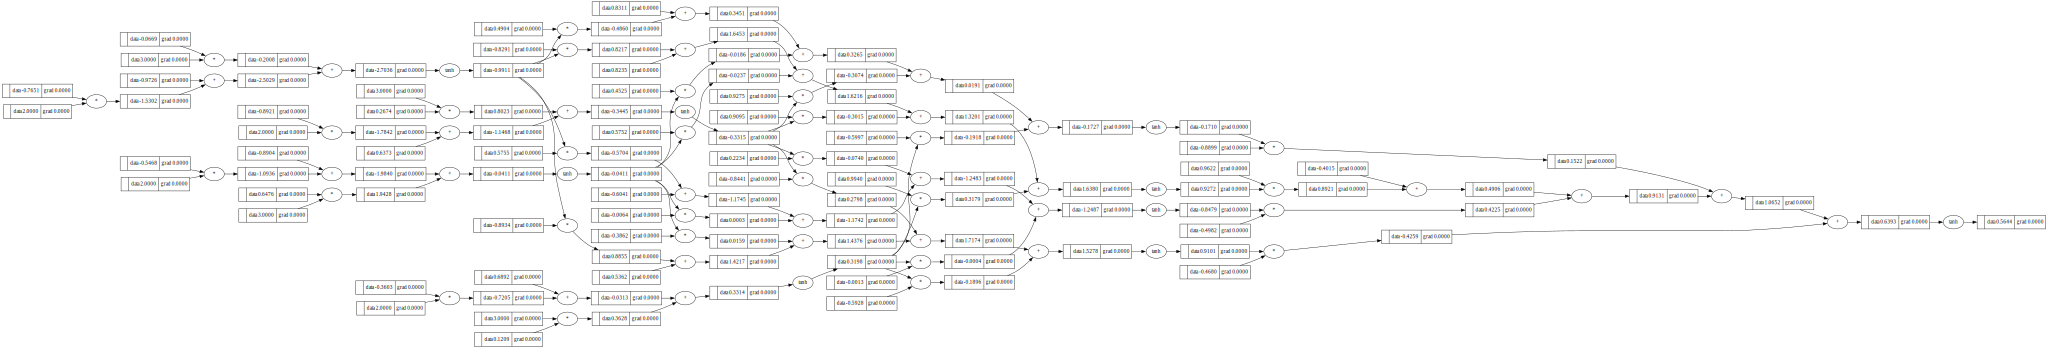

In [299]:
draw_dot(n(x))

In [300]:
xs = [
    [2.0, 3.0, -1.0 ],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0] # desired targets

ypred = [n(x) for x in xs]
ypred

[Value(data=0.23469953876053362),
 Value(data=-0.13131773243082126),
 Value(data=0.663513198054341),
 Value(data=0.22469293108745805)]

In [301]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=4.708670889169208)

In [302]:
loss.backward()

In [303]:
n.layers[0].neurons[0].w[0].grad

0.08832757019638574

In [304]:
n.layers[0].neurons[0].w[0].data

-0.7651137833811643

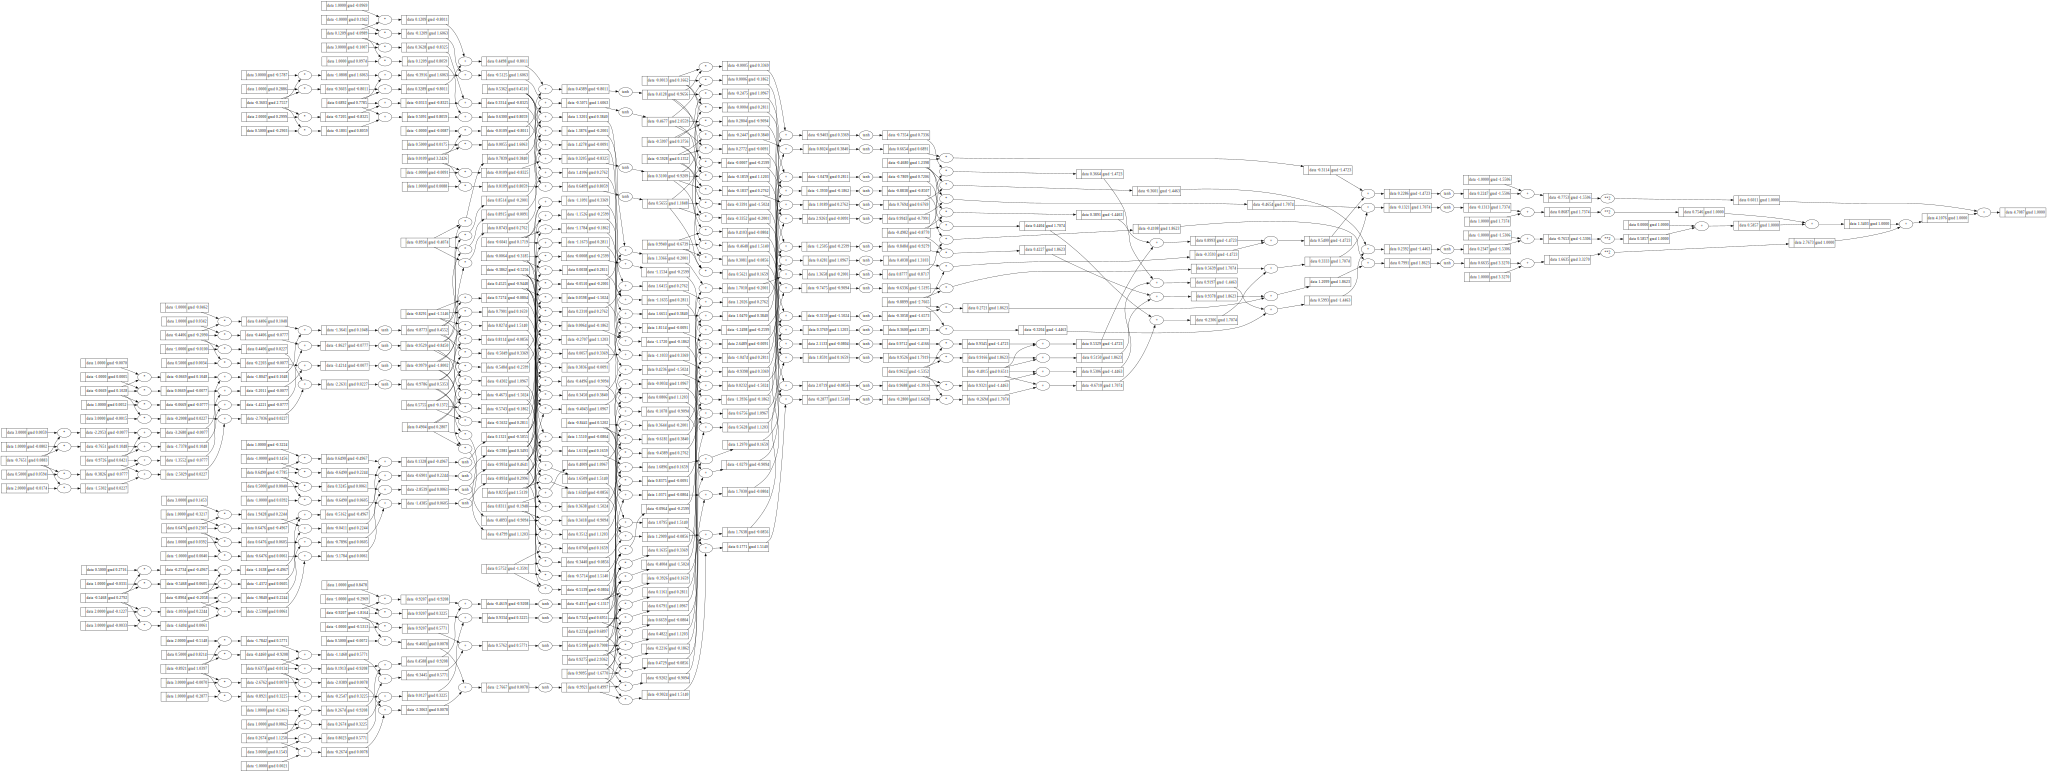

In [305]:
draw_dot(loss)

In [306]:
lr = 0.01
for p in n.parameters():
    p.data += - lr * p.grad

In [307]:
n.layers[0].neurons[0].w[0].data

-0.7659970590831282

In [308]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=4.0652262342219885)

In [311]:
epochs = 20
for i in range(epochs):
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
    print(loss)
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    for p in n.parameters():
        p.data += - lr * p.grad

print('Final loss', loss)

Value(data=1.0001088592253866)
Value(data=0.9301937682551771)
Value(data=0.8658809553149935)
Value(data=0.8067923403534343)
Value(data=0.7525492870988485)
Value(data=0.7027790359181344)
Value(data=0.6571203809325356)
Value(data=0.6152282159119185)
Value(data=0.5767768282123638)
Value(data=0.5414619928408804)
Value(data=0.5090020183520054)
Value(data=0.47913793996740783)
Value(data=0.4516330612738389)
Value(data=0.4262720295231468)
Value(data=0.40285960235043405)
Value(data=0.3812192332211012)
Value(data=0.3611915736091186)
Value(data=0.34263296408778204)
Value(data=0.32541396504038245)
Value(data=0.3094179605899651)
Final loss Value(data=0.3094179605899651)


In [310]:
ypred

[Value(data=0.5230764783564537),
 Value(data=-0.8501131127978183),
 Value(data=-0.220200915046532),
 Value(data=0.5331075866179541)]

In [312]:
ypred

[Value(data=0.7079073496488014),
 Value(data=-0.891942668157307),
 Value(data=-0.5996566550851128),
 Value(data=0.7716391815171102)]